# Generate annual/yearly zarr stores from hourly ERA5 NetCDF files on NCAR's Research Data Archive


## Overview and Warning: Please Read
- ERA5 data on NCAR is stored in hourly NetCDF files. Therefore, it is necessary to create intermediate ARCO datasets for fast processing.
- In this notebook, we read hourly data from NCAR's publicly accessible ERA5 collection using an intake catalog, compute the annual means and store the result using zarr stores.
- If you don't have write permision to save to the Research Data Archive (RDA), please save the result to your local folder.
- If you need annual means for the following variables, please don't run this notebook. The data has already been calculated and can be accessed via https from https://data.rda.ucar.edu/pythia_era5_24/annual_means/

  1) Air temperature at 2 m/ VAR_2T (https://data.rda.ucar.edu/pythia_era5_24/annual_means/temp_2m_annual_1940_2023.zarr)
     
- Otherwise, please run this script once to generate the annual means.


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | |
| [Intro to Intake](https://projectpythia.org/intake-cookbook/notebooks/intake_introduction.html) | Necessary | |
| [Understanding of Zarr](https://zarr.readthedocs.io/en/stable/) | Helpful | |

- **Time to learn**: 30 minutes

## Imports

In [1]:
import glob
import re
import matplotlib as plt
import numpy as np
import scipy as sp
import xarray as xr
import intake
import intake_esm
import pandas as pd

In [2]:
import dask
from dask.distributed import Client, performance_report
from dask_jobqueue import PBSCluster

In [18]:
######## File paths ################
rda_scratch       = "/gpfs/csfs1/collections/rda/scratch/harshah"
rda_data          = "/gpfs/csfs1/collections/rda/data/"
#########
rda_url           = 'https://data.rda.ucar.edu/'
era5_catalog      = rda_url + 'pythia_era5_24/pythia_intake_catalogs/era5_catalog.json'
#alternate_catalog = rda_data + 'pythia_era5_24/pythia_intake_catalogs/era5_catalog_opendap.json'
annual_means      =  rda_data + 'pythia_era5_24/annual_means/'
######## 
zarr_path         = rda_scratch + "/tas_zarr/"
##########
print(annual_means)

/gpfs/csfs1/collections/rda/data/pythia_era5_24/annual_means/


## Create a Dask cluster

#### Dask Introduction

[Dask](https://www.dask.org/) is a solution that enables the scaling of Python libraries. It mimics popular scientific libraries such as numpy, pandas, and xarray that enables an easier path to parallel processing without having to refactor code. 

There are 3 components to parallel processing with Dask: the client, the scheduler, and the workers. 

The Client is best envisioned as the application that sends information to the Dask cluster. In Python applications this is handled when the client is defined with `client = Client(CLUSTER_TYPE)`. A Dask cluster comprises of a single scheduler that manages the execution of tasks on workers. The `CLUSTER_TYPE` can be defined in a number of different ways.

- There is LocalCluster, a cluster running on the same hardware as the application and sharing the available resources, directly in Python with `dask.distributed`. 

- In certain JupyterHubs Dask Gateway may be available and a dedicated dask cluster with its own resources can be created dynamically with `dask.gateway`. 

- On HPC systems `dask_jobqueue` is used to connect to the HPC Slurm and PBS job schedulers to provision resources.

The `dask.distributed` client python module can also be used to connect to existing clusters. A Dask Scheduler and Workers can be deployed in containers, or on Kubernetes, without using a Python function to create a dask cluster. The `dask.distributed` Client is configured to connect to the scheduler either by container name, or by the Kubernetes service name.   

#### Select the Dask cluster type

The default will be `LocalCluster` as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [12]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [13]:
USE_DASK_GATEWAY = False

**Python function for a PBS cluster**

In [14]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-pythia-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        resource_spec = 'select=1:ncpus=1:mem=8GB',
        queue = 'casper',
        walltime = '1:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

**Python function for a Gateway Cluster**

In [15]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

**Python function for a Local Cluster**

In [16]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(4)
    return cluster

**Python logic to select the Dask Cluster type**

This uses True/False boolean logic based on the variables set in the previous cells

In [19]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

# Display cluster dashboard URL
cluster

PBSCluster(ac6b2948, 'tcp://128.117.208.94:38149', workers=0, threads=0, memory=0 B)

## Find data using intake catalog 

In [7]:
era5_cat = intake.open_esm_datastore(era5_catalog)
era5_cat

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/intake_esm/cat.py:251: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [8]:
era5_cat.df[['long_name','variable']].drop_duplicates().head()

long_name variable
0            Potential vorticity       PV
31   Specific rain water content     CRWC
62   Specific snow water content     CSWC
93                  Geopotential        Z
124                  Temperature        T

### Select variable of interest

In [9]:
######## Examples of other Variables ##############
# MTNLWRF = Outgoing Long Wave Radiation (upto a sign), Mean Top Net Long Wave Radiative Flux
# rh_cat = era5_cat.search(variable= 'R') # R =  Relative Humidity
# olr_cat = era5_cat.search(variable ='MTNLWRF')
# olr_cat
############ Access temperature data ###########
temp_cat = era5_cat.search(variable='VAR_2T',frequency = 'hourly')
temp_cat

In [10]:
# Define the xarray_open_kwargs with a compatible engine, for example, 'scipy'
xarray_open_kwargs = {
    'engine': 'h5netcdf',
    'chunks': {},  # Specify any chunking if needed
    'backend_kwargs': {}  # Any additional backend arguments if required
}

In [11]:
%%time
dset_temp = temp_cat.to_dataset_dict(xarray_open_kwargs=xarray_open_kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'datatype.step_type'


CPU times: user 1min 37s, sys: 3.38 s, total: 1min 41s
Wall time: 3min 44s


In [12]:
dset_temp.keys()

dict_keys(['an.sfc'])

In [13]:
temp_2m = dset_temp['an.sfc'].VAR_2T
temp_2m

<xarray.DataArray 'VAR_2T' (time: 737784, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(737784, 721, 1440), dtype=float32, chunksize=(27, 139, 277), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-01-01 ... 2024-02-29T23:00:00
    utc_date   (time) int32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/14)
    long_name:                                          2 metre temperature
    short_name:                                         2t
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    ...                                                 ...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    number_of_significant_digits:                       7
    QuantizeBitGroomNumberOfSignificantDigits:          7

In [14]:
temp_2m_annual = temp_2m.resample(time='1Y').mean()
temp_2m_annual

<xarray.DataArray 'VAR_2T' (time: 85, latitude: 721, longitude: 1440)>
dask.array<transpose, shape=(85, 721, 1440), dtype=float32, chunksize=(1, 139, 277), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (12/14)
    long_name:                                          2 metre temperature
    short_name:                                         2t
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    ...                                                 ...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    number_of_significant_digits:                       7
    QuantizeBitGroomNumberOfSignificantDigits:          7

### Save the notbeook

In [15]:
# temp_2m_annual.to_dataset().to_zarr(zarr_path + "e5_tas2m_monthly_1940_2023.zarr)

In [16]:
temp_2m_monthly = xr.open_zarr(zarr_path + "e5_tas2m_monthly_1940_2023.zarr").VAR_2T
temp_2m_monthly

<xarray.DataArray 'VAR_2T' (time: 1009, latitude: 721, longitude: 1440)>
dask.array<open_dataset-VAR_2T, shape=(1009, 721, 1440), dtype=float32, chunksize=(1000, 721, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-01-31 1940-02-29 ... 2024-01-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [25]:
temp_2m_annual = temp_2m_monthly.resample(time='1Y').mean()
temp_2m_annual = temp_2m_annual.chunk({'latitude':721,'longitude':1440})
temp_2m_annual = temp_2m_annual.drop_isel({'time':-1}) # Drop 2024 data
temp_2m_annual

<xarray.DataArray 'VAR_2T' (time: 84, latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(84, 721, 1440), dtype=float32, chunksize=(84, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

#### Save annual mean to annual_means folder within rda_data

In [31]:
# %%time
# temp_2m_annual.to_dataset().to_zarr(annual_means + 'temp_2m_annual_1940_2023.zarr',mode='w')

CPU times: user 392 ms, sys: 26.6 ms, total: 419 ms
Wall time: 6.36 s


In [33]:
temp_2m_annual = xr.open_zarr(annual_means + 'temp_2m_annual_1940_2023.zarr').VAR_2T
temp_2m_annual 

<xarray.DataArray 'VAR_2T' (time: 84, latitude: 721, longitude: 1440)>
dask.array<open_dataset-VAR_2T, shape=(84, 721, 1440), dtype=float32, chunksize=(84, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

CPU times: user 118 ms, sys: 11.5 ms, total: 130 ms
Wall time: 389 ms


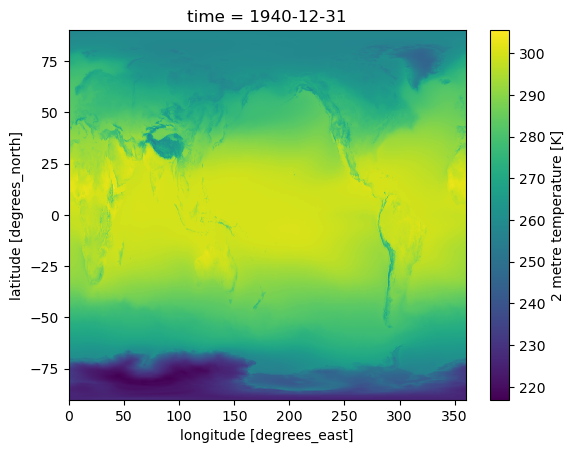

In [34]:
%%time
temp_2m_annual.isel(time=0).plot()

### Close up the cluster

In [35]:
cluster.close()